# Do the SSN range residuals imply radar error?

The SSN range residuals must imply radar error of some kind unless a dynamically correct trajectory can be found that explains them otherwise.

An additional least square fit is obtained below simultaneously to both SSN and Goldstone range rates with estimated velocity lags, to check for possible improvement over the [simultaneous range fit](near_sim_ssn_revfit_range.ipynb). 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas = []
sim_altair_rv = []
sim_millstone_rv = []
sim_dss25_rv = []

for e in ssn_epochs:
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrAltair.rv_with_ratelag(rv, e)
    sim_altair_rv.append(sim_rv)
    sim_altair_r, sim_altair_rr = ssrAltair.range_and_rate(sim_rv, e)

    sim_rv = ssrMillstone.rv_with_ratelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_millstone_r, sim_millstone_rr = ssrMillstone.range_and_rate(sim_rv, e)


    sim_rv = dss25.rv_with_ratelag(rv, e)
    sim_dss25_rv.append(sim_rv)
    sim_dss25_r, sim_dss25_rr = dss25.range_and_rate(sim_rv, e)

    sim_meas.append([sim_altair_rr, sim_millstone_rr, sim_dss25_rr])

print(sim_meas)

[[<Quantity -8.15608157 km / s>, <Quantity -7.56627632 km / s>, <Quantity -7.6789992 km / s>], [<Quantity -8.159005 km / s>, <Quantity -7.57208732 km / s>, <Quantity -7.68104262 km / s>], [<Quantity -8.1617966 km / s>, <Quantity -7.57791307 km / s>, <Quantity -7.68294138 km / s>], [<Quantity -8.16444091 km / s>, <Quantity -7.58374715 km / s>, <Quantity -7.68467824 km / s>], [<Quantity -8.16692097 km / s>, <Quantity -7.58958241 km / s>, <Quantity -7.68623427 km / s>], [<Quantity -8.16921816 km / s>, <Quantity -7.59541088 km / s>, <Quantity -7.68758872 km / s>], [<Quantity -8.171312 km / s>, <Quantity -7.60122364 km / s>, <Quantity -7.68871875 km / s>], [<Quantity -8.17318001 km / s>, <Quantity -7.60701077 km / s>, <Quantity -7.68959928 km / s>], [<Quantity -8.17479744 km / s>, <Quantity -7.6127612 km / s>, <Quantity -7.69020271 km / s>], [<Quantity -8.17613706 km / s>, <Quantity -7.61846259 km / s>, <Quantity -7.69049865 km / s>], [<Quantity -8.17716888 km / s>, <Quantity -7.6241012 km 

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrAltair, ssrMillstone, dss25], var=0.001, debug=True)

Range constraints:
a: -8485822.711542351 -8502811.345599491
ecc: 1.811545437071758 1.8151721546634931
inc: 1.8825937595496878 1.8863627160252625


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_doppler_data(ssn_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

-1. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
0. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
1. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
2. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
3. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958946467, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
4. 0.651795 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.884478237815556, 'nu': -1.850038352972503, 'raan': 1.5400589

In [8]:
print(fitter.result.residual)

[ 0.00688778  0.0057803   0.00382844  0.00665659  0.00561412  0.00358206
  0.00641548  0.00544043  0.00332594  0.00616415  0.00525897  0.00305986
  0.00590227  0.0050695   0.00278363  0.00562954  0.00487181  0.00249706
  0.00534566  0.00466567  0.00220004  0.00505037  0.00445087  0.00189246
  0.00474342  0.00422722  0.00157432  0.0044246   0.00399457  0.00124564
  0.00409377  0.00375277  0.00090657  0.0037508   0.00350173  0.00055735
  0.00339569  0.00324142  0.00019835  0.0030285   0.00297183 -0.00016991
  0.0026494   0.00269305 -0.0005467   0.00225871  0.00240527 -0.00093109
  0.00185691  0.00210876 -0.00132185  0.0014447   0.00180393 -0.00171745
  0.00102301  0.00149137 -0.00211595  0.00059309  0.00117184 -0.00251494
  0.00015655  0.00084632 -0.00291146 -0.00028457  0.0005161  -0.00330187
 -0.00072769  0.00018277 -0.00368175 -0.00116958 -0.00015167 -0.00404568
 -0.00160626 -0.00048472 -0.00438713 -0.00203279 -0.00081334 -0.00469818
 -0.00244313 -0.00113377 -0.00496924 -0.00282987 -0

In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, e in enumerate(ssn_epochs):
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(sim_dss25_rv[i], e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

The residuals are within the same magnitude as with [the range fit](near_sim_ssn_revfit_range.ipynb). The offset by -300 m is consistent with the fact that the fit was to Doppler rather than range.

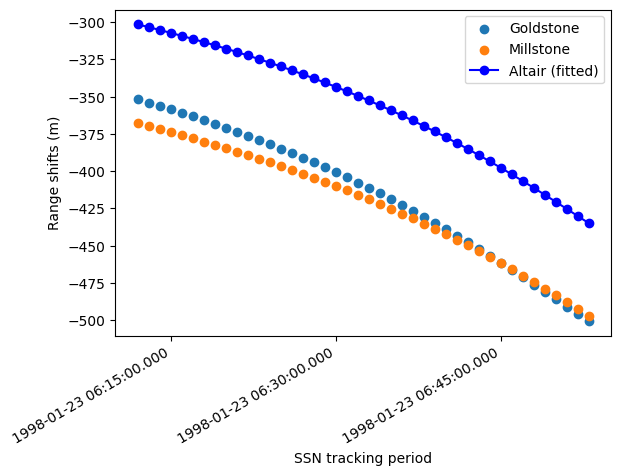

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs, millstone_shifts, label="Millstone")
    plt.plot(ssn_epochs, altair_shifts, 'bo-', label="Altair (fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for e in ssn_epochs:
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

The Doppler residuals are again of the same magnitudes as with [the range fit](near_sim_ssn_revfit_range.ipynb).

A slight further improvement may result if range and Doppler fits were attempted together, but it is clear that the SSN residuals are not the result of an unusual radar error.  

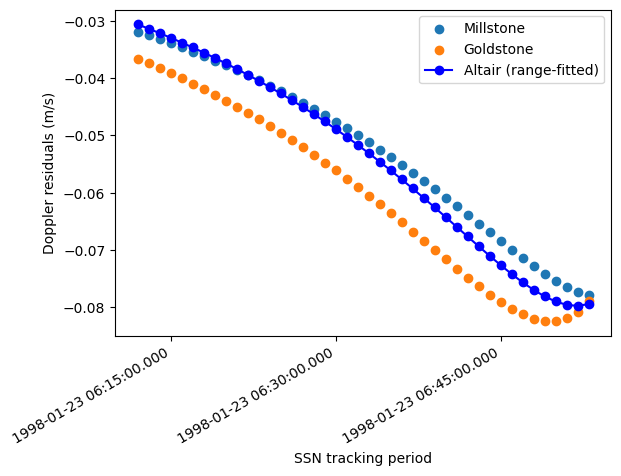

In [12]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone")
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.plot(ssn_epochs, altair_doppler, 'bo-', label="Altair (range-fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()